In [1]:
!pip uninstall pyarrow -y
!pip uninstall datasets -y
!pip install pyarrow==10.0.1 datasets==2.4.0
!pip install transformers nltk

Found existing installation: pyarrow 14.0.2
Uninstalling pyarrow-14.0.2:
  Successfully uninstalled pyarrow-14.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 10.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the 

In [2]:
!pip install accelerate -U

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [3]:
!git clone https://github.com/ryanzhumich/AESLC

Cloning into 'AESLC'...
remote: Enumerating objects: 17469, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 17469 (delta 1), reused 0 (delta 0), pack-reused 17461
Receiving objects: 100% (17469/17469), 7.36 MiB | 11.20 MiB/s, done.
Resolving deltas: 100% (48/48), done.
Updating files: 100% (18304/18304), done.


In [4]:
import os
import pandas as pd

In [5]:
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import GPT2LMHeadModel, GPT2Tokenizer, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset, DataLoader

# Ensure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [6]:
def preprocess_text(text):
    # Tokenize text
    tokens = word_tokenize(text.lower())

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and word.isalnum()]

    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back into a string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

In [7]:
# Custom dataset class
class EmailSubjectDataset(Dataset):
    def __init__(self, emails, subjects, tokenizer, max_length):
        self.emails = emails
        self.subjects = subjects
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.emails)

    def __getitem__(self, idx):
        email_text = self.emails[idx]
        subject_text = self.subjects[idx]

        # Tokenize inputs and outputs
        inputs = self.tokenizer(email_text, return_tensors='pt', max_length=self.max_length, truncation=True,
                                padding='max_length')
        outputs = self.tokenizer(subject_text, return_tensors='pt', max_length=self.max_length, truncation=True,
                                 padding='max_length')

        return {
            'input_ids': inputs.input_ids.flatten(),
            'attention_mask': inputs.attention_mask.flatten(),
            'labels': outputs.input_ids.flatten()
        }


In [8]:
def sanitize_subject(subject):
    # Remove special characters from the subject
    return re.sub(r'[^a-zA-Z0-9\s]', '', subject)

In [9]:
import os
import re

def load_emails_and_subjects(emails_directory):
    emails = []
    subjects = []

    for filename in os.listdir(emails_directory):
        file_path = os.path.join(emails_directory, filename)

        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            email_text = file.read()

            # Extract subject from email body using regex
            match = re.search(r'@subject\s+(.*)', email_text, re.IGNORECASE | re.DOTALL)

            if match:
                subject = match.group(1).strip()
                email_body = re.sub(r'@subject\n(.+)\n', '', email_text).strip()
                preprocessed_email = preprocess_text(email_body)

                emails.append(preprocessed_email)
                subjects.append(subject)

    return emails, subjects

In [10]:
train_emails, tain_subjects = load_emails_and_subjects('/content/AESLC/enron_subject_line/train')
dev_emails, dev_subjects = load_emails_and_subjects('/content/AESLC/enron_subject_line/dev')
test_emails, test_subjects = load_emails_and_subjects('/content/AESLC/enron_subject_line/test')

In [11]:
train_data = pd.DataFrame({'subject_line': tain_subjects, 'email_body': train_emails})
dev_data = pd.DataFrame({'subject_line': dev_subjects, 'email_body': dev_emails})
test_data = pd.DataFrame({'subject_line': test_subjects, 'email_body': test_emails})

In [12]:
train_data.head()

,subject_line,email_body
0,Bank of Montreal,note let know per conversation tanya review br...
1,Override letter for ABB,peter ca recall sent override letter essential...
2,Customer trip for Gary Hanks,esther gary asked send info business trip invi...
3,Caithness +,thursday october 25 2001 pm central time u can...
4,TECO EnergySource Inc.,tana eta amendment letter ready teco see could...


In [13]:
from transformers import T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained('t5-small')

def tokenize_data(data):
    inputs = [email for email in data['email_body']]
    targets = [subject for subject in data['subject_line']]
    tokenized_inputs = tokenizer(inputs, max_length=512, truncation=True, padding=True)
    tokenized_targets = tokenizer(targets, max_length=10, truncation=True, padding=True)
    return tokenized_inputs, tokenized_targets

train_inputs, train_targets = tokenize_data(train_data)
dev_inputs, dev_targets = tokenize_data(dev_data)
test_inputs, test_targets = tokenize_data(test_data)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [14]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word.lower() not in stop_words])

train_data['email_body'] = train_data['email_body'].apply(remove_stopwords)
dev_data['email_body'] = dev_data['email_body'].apply(remove_stopwords)
test_data['email_body'] = test_data['email_body'].apply(remove_stopwords)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
nltk.download('averaged_perceptron_tagger')

def pos_tagging(text):
    return nltk.pos_tag(text.split())

train_data['pos_tags'] = train_data['email_body'].apply(pos_tagging)
dev_data['pos_tags'] = dev_data['email_body'].apply(pos_tagging)
test_data['pos_tags'] = test_data['email_body'].apply(pos_tagging)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [16]:
def chunking(text):
    grammar = "NP: {<DT>?<JJ>*<NN>}"
    chunk_parser = nltk.RegexpParser(grammar)
    pos_tags = pos_tagging(text)
    return chunk_parser.parse(pos_tags)

train_data['chunks'] = train_data['email_body'].apply(chunking)
dev_data['chunks'] = dev_data['email_body'].apply(chunking)
test_data['chunks'] = test_data['email_body'].apply(chunking)


In [17]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

train_data['email_body'] = train_data['email_body'].apply(lemmatize_text)
dev_data['email_body'] = dev_data['email_body'].apply(lemmatize_text)
test_data['email_body'] = test_data['email_body'].apply(lemmatize_text)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


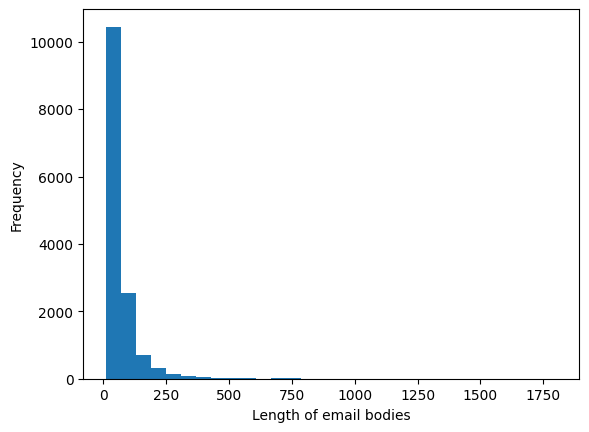

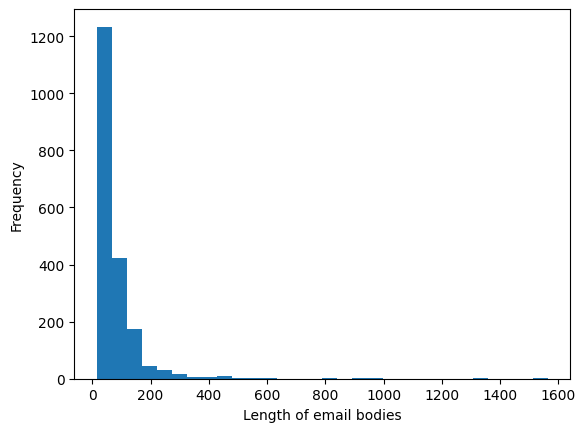

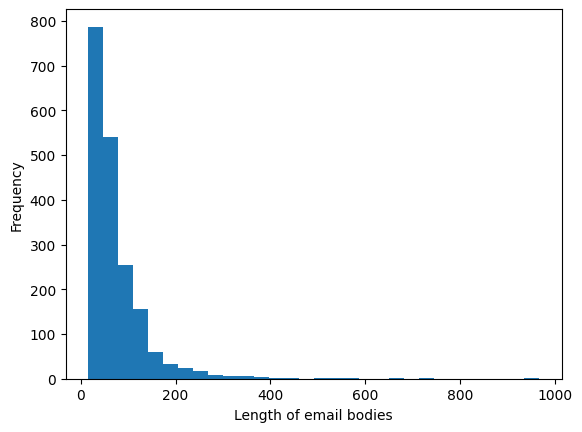

In [18]:
import matplotlib.pyplot as plt

def plot_data(data):
    lengths = [len(text.split()) for text in data['email_body']]
    plt.hist(lengths, bins=30)
    plt.xlabel('Length of email bodies')
    plt.ylabel('Frequency')
    plt.show()

plot_data(train_data)
plot_data(dev_data)
plot_data(test_data)


In [19]:
from torch.utils.data import Dataset, DataLoader
from transformers import T5ForConditionalGeneration, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np

class EmailDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs['input_ids'])

    def __getitem__(self, index):
        input_ids = self.inputs['input_ids'][index]
        attention_mask = self.inputs['attention_mask'][index]
        labels = self.targets['input_ids'][index]
        return {'input_ids': torch.tensor(input_ids), 'attention_mask': torch.tensor(attention_mask), 'labels': torch.tensor(labels)}

train_dataset = EmailDataset(train_inputs, train_targets)
dev_dataset = EmailDataset(dev_inputs, dev_targets)
test_dataset = EmailDataset(test_inputs, test_targets)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

model = T5ForConditionalGeneration.from_pretrained('t5-small')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)
total_steps = len(train_loader) * 3
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

def train_epoch(model, data_loader, optimizer, device, scheduler):
    model.train()
    losses = []
    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return np.mean(losses)

EPOCHS = 3
for epoch in range(EPOCHS):
    train_loss = train_epoch(model, train_loader, optimizer, device, scheduler)
    print(f'Train loss {train_loss}')


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Train loss 1.9675395420218438
Train loss 1.4240287857702894
Train loss 1.3260153572314994


In [20]:
!pip install datasets

In [21]:
#!pip uninstall pyarrow -y
#!pip uninstall datasets -y
#!pip install pyarrow==10.0.1 datasets==2.4.0

In [22]:
from datasets import load_metric

In [23]:
def evaluate(model, data_loader, device):
    model.eval()
    metric = load_metric("rouge")
    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with torch.no_grad():
            generated_ids = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=10, num_beams=2, repetition_penalty=2.5, length_penalty=1.0, early_stopping=True)

        preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
        refs = [tokenizer.decode(l, skip_special_tokens=True, clean_up_tokenization_spaces=True) for l in labels]

        metric.add_batch(predictions=preds, references=refs)

    final_score = metric.compute()
    return final_score

In [24]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=de21cf69fa12408618541c8d0dc3facdf1d172ceaa64d627c12023493cdae302
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [25]:
score = evaluate(model, test_loader, device)
print(score)

{'rouge1': AggregateScore(low=Score(precision=0.20591482723729562, recall=0.1584711031579471, fmeasure=0.17197893673890527), mid=Score(precision=0.21801953730075413, recall=0.16655705041722818, fmeasure=0.180949306028005), high=Score(precision=0.23117717754293038, recall=0.1769002492130112, fmeasure=0.19175372568145418)), 'rouge2': AggregateScore(low=Score(precision=0.08034182468895218, recall=0.05653440888422528, fmeasure=0.06278778766121375), mid=Score(precision=0.0898590915904662, recall=0.06317987058412036, fmeasure=0.07046211629107757), high=Score(precision=0.09989032129116078, recall=0.07039413443761558, fmeasure=0.07817939107354131)), 'rougeL': AggregateScore(low=Score(precision=0.1983611954313026, recall=0.15106971093789007, fmeasure=0.16450136082874822), mid=Score(precision=0.20915467446159952, recall=0.15947852645780208, fmeasure=0.17326428089806906), high=Score(precision=0.22140408213827642, recall=0.16900698920701496, fmeasure=0.1831626788886761)), 'rougeLsum': AggregateSco

In [26]:
sample_email = """
All: Attached you will find a list that reflects your seat assignments for Business Continuity Planning (BCP).
These seats are located on the 30th and 31st Floors of Enron Center North (ECN).
As previously communicated, you will report to these designated seats in the event of an outage in ECS.
The exception to this is as follows: If your seat assignment is located on the 31st Floor, you will report to your original location that you occupied prior to your move into ECS.
This will hold true until the Monday after Thanksgiving, as we will have the 31st floor seats set up at that time.
Testing: Once you have moved to ECS, if you would like to test your BCP location, you will be able to test your seat for functionality every Thursday from 3-6pm.
Testing is not required, but is highly recommended.
If anyone has any questions or concerns about these procedures, please feel free to contact me at any time.
Regards,

@subject
BCP Seat Assignments

@ann0
your seat assignments for business continuity planning (bcp).

@ann1
bcp seat assignments

@ann2
here are your seat assignments for the business continuity planning event
"""
inputs = tokenizer(sample_email, return_tensors="pt").input_ids.to(device)
outputs = model.generate(inputs, max_length=10, num_beams=2, repetition_penalty=2.5, length_penalty=1.0, early_stopping=True)
print("Generated Subject Line:", tokenizer.decode(outputs[0], skip_special_tokens=True))

Generated Subject Line: BCP Seat Assignments @ann0


In [27]:
sample_email = "Hi team, the project deadline has been extended to next Friday. Please ensure all deliverables are completed by then. Thanks."
inputs = tokenizer(sample_email, return_tensors="pt").input_ids.to(device)
outputs = model.generate(inputs, max_length=10, num_beams=2, repetition_penalty=2.5, length_penalty=1.0, early_stopping=True)
print("Generated Subject Line:", tokenizer.decode(outputs[0], skip_special_tokens=True))

Generated Subject Line: Thank you.


In [28]:
sample_email = "Michelle;  This is the presentation which was provided to the HR VP's.The HR VPs were tasked with going off to met their BU OTCs and devise plans around the three components.We are currently collating those plans into one document.We'll send that along to you when completed.Pls call if you have any questions."
inputs = tokenizer(sample_email, return_tensors="pt").input_ids.to(device)
outputs = model.generate(inputs, max_length=10, num_beams=2, repetition_penalty=2.5, length_penalty=1.0, early_stopping=True)
print("Generated Subject Line:", tokenizer.decode(outputs[0], skip_special_tokens=True))

Generated Subject Line: The HRVPs were tasked with


In [29]:
sample_email = "To confirm:  Mark Thomas Mike Presley  both previously on the list for Netco's Market Risk/Research Group have resigned.I'm combing the Estate for replacements.DP"
inputs = tokenizer(sample_email, return_tensors="pt").input_ids.to(device)
outputs = model.generate(inputs, max_length=10, num_beams=2, repetition_penalty=2.5, length_penalty=1.0, early_stopping=True)
print("Generated Subject Line:", tokenizer.decode(outputs[0], skip_special_tokens=True))

Generated Subject Line: I'm combing the Estate for replacement


In [30]:
model.save_pretrained('./t5-email-subject-generator')
tokenizer.save_pretrained('./t5-email-subject-generator')

('./t5-email-subject-generator/tokenizer_config.json',
 './t5-email-subject-generator/special_tokens_map.json',
 './t5-email-subject-generator/spiece.model',
 './t5-email-subject-generator/added_tokens.json')